<a href="https://colab.research.google.com/github/450586509/reinforcement-learning-practice/blob/master/08_rl_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#### 任务 
Hebrew->English machine translation for words and short phrases

In [0]:
# If True, only translates phrases shorter than 20 characters (way easier).
EASY_MODE = True
# Useful for initial coding.
# If false, works with all phrases (please switch to this mode for homework assignment)

MODE = "he-to-en"  # way we translate. Either "he-to-en" or "en-to-he"
# maximal length of _generated_ output, does not affect training
MAX_OUTPUT_LENGTH = 50 if not EASY_MODE else 20
REPORT_FREQ = 100  # how often to evaluate validation score

数据预处理


数据的保存格式为：{ word1:[translation1,translation2,...], word2:[...],...}.

In [51]:
import numpy as np
from collections import defaultdict
word_to_translation = defaultdict(list)  # our dictionary

bos = '_'
eos = ';'

with open("main_dataset_small.txt") as fin:
    for line in fin:
        en, he = line[:-1].lower().replace(bos, ' ').replace(eos,                                         ' ').split('\t')
        word, trans = (he, en) if MODE == 'he-to-en' else (en, he)
        if len(word) < 3:
            continue
        if EASY_MODE:
            if max(len(word), len(trans)) > 20:
                continue
        word_to_translation[word].append(trans)
print("size = ", len(word_to_translation))

size =  486


In [0]:
# get all unique lines in source language
all_words = np.array(list(word_to_translation.keys()))
# get all unique lines in translation language
all_translations = np.array(
    [ts for all_ts in word_to_translation.values() for ts in all_ts])

利用sklearn.model_selection中的工具分隔数据集

In [0]:
from sklearn.model_selection import train_test_split
train_words, test_words = train_test_split(
    all_words, test_size=0.1, random_state=42)

### 构造Vocab类。
- 把字符转为数字
- 把数字转为字符

In [0]:
import numpy as np


class Vocab:
    def __init__(self, tokens, bos="__BOS__", eos="__EOS__", sep=''):
        """
        A special class that handles tokenizing and detokenizing
        """
        assert bos in tokens, eos in tokens
        self.tokens = tokens
        self.token_to_ix = {t: i for i, t in enumerate(tokens)}

        self.bos = bos
        self.bos_ix = self.token_to_ix[bos]
        self.eos = eos
        self.eos_ix = self.token_to_ix[eos]
        self.sep = sep

    def __len__(self):
        return len(self.tokens)

    @staticmethod
    def from_lines(lines, bos="__BOS__", eos="__EOS__", sep=''):
        flat_lines = sep.join(list(lines))
        flat_lines = list(flat_lines.split(sep)) if sep else list(flat_lines)
        tokens = list(set(sep.join(flat_lines)))
        tokens = [t for t in tokens if t not in (bos, eos) and len(t) != 0]
        tokens = [bos, eos] + tokens
        return Vocab(tokens, bos, eos, sep)

    def tokenize(self, string):
        """converts string to a list of tokens"""
        tokens = list(filter(len, string.split(self.sep))) \
            if self.sep != '' else list(string)
        return [self.bos] + tokens + [self.eos]

    def to_matrix(self, lines, max_len=None):
        """
        convert variable length token sequences into  fixed size matrix
        example usage:
        >>>print( as_matrix(words[:3],source_to_ix))
        [[15 22 21 28 27 13 -1 -1 -1 -1 -1]
         [30 21 15 15 21 14 28 27 13 -1 -1]
         [25 37 31 34 21 20 37 21 28 19 13]]
        """
        max_len = max_len or max(map(len, lines)) + 2  # 2 for bos and eos

        matrix = np.zeros((len(lines), max_len), dtype='int32') + self.eos_ix
        #print("matrix[0]={}".format(matrix[0]))
        for i, seq in enumerate(lines):
            tokens = self.tokenize(seq)
            row_ix = list(map(self.token_to_ix.get, tokens))[:max_len]
            matrix[i, :len(row_ix)] = row_ix

        return matrix

    def to_lines(self, matrix, crop=True):
        """
        Convert matrix of token ids into strings
        :param matrix: matrix of tokens of int32, shape=[batch,time]
        :param crop: if True, crops BOS and EOS from line
        :return:
        """
        lines = []
        for line_ix in map(list, matrix):
            if crop:
                if line_ix[0] == self.bos_ix:
                    line_ix = line_ix[1:]
                if self.eos_ix in line_ix:
                    line_ix = line_ix[:line_ix.index(self.eos_ix)]
            line = self.sep.join(self.tokens[i] for i in line_ix)
            lines.append(line)
        return lines

In [55]:

inp_voc = Vocab.from_lines(''.join(all_words), bos=bos, eos=eos, sep='')
out_voc = Vocab.from_lines(''.join(all_translations), bos=bos, eos=eos, sep='')

# Here's how you cast lines into ids and backwards.
batch_lines = all_words[:5]
batch_ids = inp_voc.to_matrix(batch_lines)
batch_lines_restored = inp_voc.to_lines(batch_ids)

print("lines")
print(batch_lines)
print("\nwords to ids (0 = bos, 1 = eos):")
print(batch_ids)
print("\nback to words")
print(batch_lines_restored)

lines
['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו' 'אלבמה' 'אכילס']

words to ids (0 = bos, 1 = eos):
[[ 0 44 42 36 10 14 47 59  1  1  1  1  1  1]
 [ 0 44 11 24 14 47 59 40 13  7 44 30 14  1]
 [ 0 44  7  9 46 11  1  1  1  1  1  1  1  1]
 [ 0 44  7  9 16 34  1  1  1  1  1  1  1  1]
 [ 0 44 10 14  7 30  1  1  1  1  1  1  1  1]]

back to words
['אנרכיזם', 'אוטיזם קלאסי', 'אלבדו', 'אלבמה', 'אכילס']


(array([ 7., 18., 35., 41., 45., 71.,  0., 68., 25., 28., 23., 20., 23.,
         0., 17., 14., 17., 16., 13., 10.]),
 array([ 3.  ,  3.85,  4.7 ,  5.55,  6.4 ,  7.25,  8.1 ,  8.95,  9.8 ,
        10.65, 11.5 , 12.35, 13.2 , 14.05, 14.9 , 15.75, 16.6 , 17.45,
        18.3 , 19.15, 20.  ]),
 <a list of 20 Patch objects>)

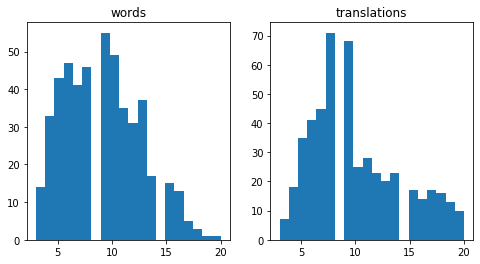

In [56]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.figure(figsize=[8, 4])
plt.subplot(1, 2, 1)
plt.title("words")
plt.hist(list(map(len, all_words)), bins=20)

plt.subplot(1, 2, 2)
plt.title('translations')
plt.hist(list(map(len, all_translations)), bins=20)

### 3.实现Encoder-Decoder模型

seq2seq模型model提供以下接口：
- model.symbolic_translate(inp, **flags)-> out, logp：输入为：
- model.symbolic_score(inp, out, **flags) -> logp
- model.weights：所有层的权重。

In [57]:
import tensorflow as tf
import tensorflow.keras.layers as L
%tensorflow_version 1.x 
tf.reset_default_graph()
s = tf.InteractiveSession()

# ^^^ if you get "variable *** already exists": re-run this cell again

/usr/local/lib/python3.6/dist-packages/tensorflow_core/python/client/session.py:1750: UserWarning: An interactive session is already active. This can cause out-of-memory errors in some cases. You must explicitly call `InteractiveSession.close()` to release resources held by the other session(s).
  warnings.warn('An interactive session is already active. This can '


In [0]:
# 本部分实现单层的GRU encoder-decoder模型。
# 注意事项：
# 1: when using several recurrent layers TF can mixed up the weights of different recurrent layers.
# In that case, make sure you both create AND use each rnn/gru/lstm/custom layer in a unique variable scope
# e.g. with tf.variable_scope("first_lstm"): new_cell, new_out = self.lstm_1(...)
#      with tf.variable_scope("second_lstm"): new_cell2, new_out2 = self.lstm_2(...)
# Note 2: everything you need for decoding should be stored in model state (output list of both encode and decode)
# e.g. for attention, you should store all encoder sequence and input mask
# there in addition to lstm/gru states.

class BasicTranslationModel:
    def __init__(self, name, inp_voc, out_voc,
                 emb_size, hid_size,):

        self.name = name
        self.inp_voc = inp_voc
        self.out_voc = out_voc

        with tf.variable_scope(name):
            self.emb_inp = L.Embedding(len(inp_voc), emb_size)
            self.emb_out = L.Embedding(len(out_voc), emb_size)
            self.enc0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.dec_start = L.Dense(hid_size)
            self.dec0 = tf.nn.rnn_cell.GRUCell(hid_size)
            self.logits = L.Dense(len(out_voc))

            # run on dummy output to .build all layers (and therefore create
            # weights)
            inp = tf.placeholder('int32', [None, None])
            out = tf.placeholder('int32', [None, None])
            h0 = self.encode(inp)
            h1 = self.decode(h0, out[:, 0])
            # h2 = self.decode(h1,out[:,1]) etc.

        self.weights = tf.get_collection(
            tf.GraphKeys.TRAINABLE_VARIABLES, scope=name)

    def encode(self, inp, **flags):
        """
        Takes symbolic input sequence, computes initial state
        :param inp: matrix of input tokens [batch, time]
        :return: a list of initial decoder state tensors
        """
        inp_lengths = infer_length(inp, self.inp_voc.eos_ix)
        inp_emb = self.emb_inp(inp)

        _, enc_last = tf.nn.dynamic_rnn(
            self.enc0, inp_emb,
            sequence_length=inp_lengths,
            dtype=inp_emb.dtype)

        dec_start = self.dec_start(enc_last)
        return [dec_start]

    def decode(self, prev_state, prev_tokens, **flags):
        """
        Takes previous decoder state and tokens, returns new state and logits
        :param prev_state: a list of previous decoder state tensors
        :param prev_tokens: previous output tokens, an int vector of [batch_size]
        :return: a list of next decoder state tensors, a tensor of logits [batch,n_tokens]
        """

        [prev_dec] = prev_state

        prev_emb = self.emb_out(prev_tokens[:, None])[:, 0]

        new_dec_out, new_dec_state = self.dec0(prev_emb, prev_dec)

        output_logits = self.logits(new_dec_out)

        return [new_dec_state], output_logits

    def symbolic_score(self, inp, out, eps=1e-30, **flags):
        """
        Takes symbolic int32 matrices of hebrew words and their english translations.
        Computes the log-probabilities of all possible english characters given english prefices and hebrew word.
        :param inp: input sequence, int32 matrix of shape [batch,time]
        :param out: output sequence, int32 matrix of shape [batch,time]
        :return: log-probabilities of all possible english characters of shape [bath,time,n_tokens]
        NOTE: log-probabilities time axis  is synchronized with out
        In other words, logp are probabilities of __current__ output at each tick, not the next one
        therefore you can get likelihood as logprobas * tf.one_hot(out,n_tokens)
        """
        first_state = self.encode(inp, **flags)

        batch_size = tf.shape(inp)[0]
        bos = tf.fill([batch_size], self.out_voc.bos_ix)
        first_logits = tf.log(tf.one_hot(bos, len(self.out_voc)) + eps)

        def step(blob, y_prev):
            h_prev = blob[:-1]
            h_new, logits = self.decode(h_prev, y_prev, **flags)
            return list(h_new) + [logits]

        results = tf.scan(step, initializer=list(first_state) + [first_logits],
                          elems=tf.transpose(out))

        # gather state and logits, each of shape [time,batch,...]
        states_seq, logits_seq = results[:-1], results[-1]

        # add initial state and logits
        logits_seq = tf.concat((first_logits[None], logits_seq), axis=0)

        # convert from [time,batch,...] to [batch,time,...]
        logits_seq = tf.transpose(logits_seq, [1, 0, 2])

        return tf.nn.log_softmax(logits_seq)

    def symbolic_translate(
            self,
            inp,
            greedy=False,
            max_len=None,
            eps=1e-30,
            **flags):
        """
        takes symbolic int32 matrix of hebrew words, produces output tokens sampled
        from the model and output log-probabilities for all possible tokens at each tick.
        :param inp: input sequence, int32 matrix of shape [batch,time]
        :param greedy: if greedy, takes token with highest probablity at each tick.
            Otherwise samples proportionally to probability.
        :param max_len: max length of output, defaults to 2 * input length
        :return: output tokens int32[batch,time] and
                 log-probabilities of all tokens at each tick, [batch,time,n_tokens]
        """
        first_state = self.encode(inp, **flags)

        batch_size = tf.shape(inp)[0]
        bos = tf.fill([batch_size], self.out_voc.bos_ix)
        first_logits = tf.log(tf.one_hot(bos, len(self.out_voc)) + eps)
        max_len = tf.reduce_max(tf.shape(inp)[1]) * 2

        def step(blob, t):
            h_prev, y_prev = blob[:-2], blob[-1]
            h_new, logits = self.decode(h_prev, y_prev, **flags)
            y_new = (
                tf.argmax(logits, axis=-1) if greedy
                else tf.multinomial(logits, 1)[:, 0]
            )
            return list(h_new) + [logits, tf.cast(y_new, y_prev.dtype)]

        results = tf.scan(
            step,
            initializer=list(first_state) + [first_logits, bos],
            elems=[tf.range(max_len)],
        )

        # gather state, logits and outs, each of shape [time,batch,...]
        states_seq, logits_seq, out_seq = (
            results[:-2], results[-2], results[-1]
        )

        # add initial state, logits and out
        logits_seq = tf.concat((first_logits[None], logits_seq), axis=0)
        out_seq = tf.concat((bos[None], out_seq), axis=0)
        states_seq = [
            tf.concat((init[None], states), axis=0)
            for init, states in zip(first_state, states_seq)
        ]

        # convert from [time,batch,...] to [batch,time,...]
        logits_seq = tf.transpose(logits_seq, [1, 0, 2])
        out_seq = tf.transpose(out_seq)
        states_seq = [
            tf.transpose(states, [1, 0] + list(range(2, states.shape.ndims)))
            for states in states_seq
        ]

        return out_seq, tf.nn.log_softmax(logits_seq)


### Utility functions ###

def initialize_uninitialized(sess=None):
    """
    Initialize unitialized variables, doesn't affect those already initialized
    :param sess: in which session to initialize stuff. Defaults to tf.get_default_session()
    """
    sess = sess or tf.get_default_session()
    global_vars = tf.global_variables()
    is_not_initialized = sess.run(
        [tf.is_variable_initialized(var) for var in global_vars]
    )
    not_initialized_vars = [
        v for (v, f)
        in zip(global_vars, is_not_initialized)
        if not f
    ]

    if len(not_initialized_vars):
        sess.run(tf.variables_initializer(not_initialized_vars))


def infer_length(seq, eos_ix, time_major=False, dtype=tf.int32):
    """
    compute length given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: lengths, int32 vector of shape [batch]
    """
    axis = 0 if time_major else 1
    is_eos = tf.cast(tf.equal(seq, eos_ix), dtype)
    count_eos = tf.cumsum(is_eos, axis=axis, exclusive=True)
    lengths = tf.reduce_sum(tf.cast(tf.equal(count_eos, 0), dtype), axis=axis)
    return lengths


def infer_mask(seq, eos_ix, time_major=False, dtype=tf.float32):
    """
    compute mask given output indices and eos code
    :param seq: tf matrix [time,batch] if time_major else [batch,time]
    :param eos_ix: integer index of end-of-sentence token
    :returns: mask, float32 matrix with '0's and '1's of same shape as seq
    """
    axis = 0 if time_major else 1
    lengths = infer_length(seq, eos_ix, time_major=time_major)
    mask = tf.sequence_mask(lengths, maxlen=tf.shape(seq)[axis], dtype=dtype)
    if time_major:
        mask = tf.transpose(mask)
    return mask


def select_values_over_last_axis(values, indices):
    """
    Auxiliary function to select logits corresponding to chosen tokens.
    :param values: logits for all actions: float32[batch,tick,action]
    :param indices: action ids int32[batch,tick]
    :returns: values selected for the given actions: float[batch,tick]
    """
    assert values.shape.ndims == 3 and indices.shape.ndims == 2
    batch_size, seq_len = tf.shape(indices)[0], tf.shape(indices)[1]
    batch_i = tf.tile(tf.range(0, batch_size)[:, None], [1, seq_len])
    time_i = tf.tile(tf.range(0, seq_len)[None, :], [batch_size, 1])
    indices_nd = tf.stack([batch_i, time_i, indices], axis=-1)

    return tf.gather_nd(values, indices_nd)

In [0]:
model = BasicTranslationModel('model', inp_voc, out_voc,emb_size=64, hid_size=128)

s.run(tf.global_variables_initializer())

In [60]:
# Play around with symbolic_translate and symbolic_score
inp = tf.placeholder_with_default(np.random.randint(
    0, 10, [3, 5], dtype='int32'), [None, None])
out = tf.placeholder_with_default(np.random.randint(
    0, 10, [3, 5], dtype='int32'), [None, None])

# translate inp (with untrained model)
sampled_out, logp = model.symbolic_translate(inp, greedy=False)
print("\nSymbolic_translate output:\n", sampled_out, logp)
print("\nSample translations:\n", s.run(sampled_out))

# score logp(out | inp) with untrained input
logp = model.symbolic_score(inp, out)
print("\nSymbolic_score output:\n", logp)
print("\nLog-probabilities (clipped):\n", s.run(logp)[:, :2, :5])




Symbolic_translate output:
 Tensor("transpose_1:0", shape=(?, ?), dtype=int32) Tensor("LogSoftmax:0", shape=(?, ?, 49), dtype=float32)

Sample translations:
 [[ 0 17 19  0 36 17 39 33  2 31  4]
 [ 0  3 11  3 10 12 24 17 39 33 11]
 [ 0 10 41 14 12 35 43  1  2 19 32]]

Symbolic_score output:
 Tensor("LogSoftmax_1:0", shape=(?, ?, 49), dtype=float32)

Log-probabilities (clipped):
 [[[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -3.8931136  -3.8981245  -3.895202   -3.8944452  -3.8811853]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -3.8858316  -3.9041443  -3.8990376  -3.8946145  -3.89851  ]]

 [[  0.        -69.07755   -69.07755   -69.07755   -69.07755  ]
  [ -3.88896    -3.9152758  -3.8899417  -3.8944757  -3.9005055]]]


In [0]:
# Prepare any operations you want here
input_sequence = tf.placeholder('int32', [None, None])
greedy_translations, logp = model.symbolic_translate(input_sequence, greedy=True)


def translate(lines):
    """
    You are given a list of input lines. 
    Make your neural network translate them.
    :return: a list of output lines
    """
    # Convert lines to a matrix of indices
    lines_ix = inp_voc.to_matrix(lines)
    print("lines_ix shape={}".format(lines_ix.shape))

    # Compute translations in form of indices
    trans_ix = s.run(greedy_translations, {input_sequence:lines_ix})

    # Convert translations back into strings
    return out_voc.to_lines(trans_ix)



In [62]:
print("Sample inputs:", all_words[:3])
print("Dummy translations:", translate(all_words[:3]))

assert isinstance(greedy_translations,
                  tf.Tensor) and greedy_translations.dtype.is_integer, "trans must be a tensor of integers (token ids)"
assert translate(all_words[:3]) == translate(
    all_words[:3]), "make sure translation is deterministic (use greedy=True and disable any noise layers)"
assert type(translate(all_words[:3])) is list and (type(translate(all_words[:1])[0]) is str or type(
    translate(all_words[:1])[0]) is unicode), "translate(lines) must return a sequence of strings!"
print("Tests passed!")

Sample inputs: ['אנרכיזם' 'אוטיזם קלאסי' 'אלבדו']
lines_ix shape=(3, 14)
Dummy translations: ['óóóóóóóóóóóóóóóóóóóóóóóóóóóó', 'óóóóóóóóóóóóóóóóóóóóóóóóóóóó', 'óóóóóóóóóóóóóóóóóóóóóóóóóóóó']
lines_ix shape=(3, 14)
lines_ix shape=(3, 14)
lines_ix shape=(3, 14)
lines_ix shape=(1, 9)
Tests passed!


In [0]:
### 打分函数

In [64]:
!pip install editdistance
import editdistance  # !pip install editdistance


def get_distance(word, trans):
    """
    A function that takes word and predicted translation
    and evaluates (Levenshtein's) edit distance to closest correct translation
    """
    references = word_to_translation[word]
    assert len(references) != 0, "wrong/unknown word"
    return min(editdistance.eval(trans, ref) for ref in references)


def score(words, bsize=8):
    """a function that computes levenshtein distance for bsize random samples"""
    assert isinstance(words, np.ndarray)

    batch_words = np.random.choice(words, size=bsize, replace=False)
    batch_trans = translate(batch_words)

    distances = list(map(get_distance, batch_words, batch_trans))

    return np.array(distances, dtype='float32')

In [65]:
[score(test_words, 10).mean() for _ in range(5)]


lines_ix shape=(10, 19)
lines_ix shape=(10, 21)
lines_ix shape=(10, 20)
lines_ix shape=(10, 17)
lines_ix shape=(10, 19)


[37.4, 41.6, 39.5, 33.6, 37.3]

### 开始训练

In [0]:
# import utility functions
#from basic_model_tf import initialize_uninitialized, infer_length, infer_mask, select_values_over_last_axis


class supervised_training:

    # variable for inputs and correct answers
    input_sequence = tf.placeholder('int32', [None, None])
    reference_answers = tf.placeholder('int32', [None, None])

    # Compute log-probabilities of all possible tokens at each step. Use model interface.
    logprobs_seq = model.symbolic_score(input_sequence, reference_answers)

    # compute mean crossentropy
    crossentropy = - select_values_over_last_axis(logprobs_seq, reference_answers)

    mask = infer_mask(reference_answers, out_voc.eos_ix)

    loss = tf.reduce_sum(crossentropy * mask)/tf.reduce_sum(mask)

    # Build weights optimizer. Use model.weights to get all trainable params.
    train_step = tf.train.AdamOptimizer().minimize(loss)


# intialize optimizer params while keeping model intact
initialize_uninitialized(s)

In [67]:
import random


def sample_batch(words, word_to_translation, batch_size):
    """
    sample random batch of words and random correct translation for each word
    example usage:
    batch_x,batch_y = sample_batch(train_words, word_to_translations,10)
    """
    # choose words
    batch_words = np.random.choice(words, size=batch_size)

    # choose translations
    batch_trans_candidates = list(map(word_to_translation.get, batch_words))
    batch_trans = list(map(random.choice, batch_trans_candidates))

    return inp_voc.to_matrix(batch_words), out_voc.to_matrix(batch_trans)
    
bx, by = sample_batch(train_words, word_to_translation, batch_size=3)
print("Source:")
print(bx)
print("Target:")
print(by)

Source:
[[ 0 15 14 47 14 13 34 40 44 24 11 16 14 23  1  1  1  1  1]
 [ 0 34 44 11 13 14 14 42 11 30 40 34 44 24  7 42 24 14  1]
 [ 0 44  9 20  7 11 59  1  1  1  1  1  1  1  1  1  1  1  1]]
Target:
[[ 0 16  3 29  7 25 14 26 45 43 30 23 25 14 23  1]
 [ 0 16  3 46 16  6  3 25 14 26 29 14  2 16  6  1]
 [ 0 16 39 23 16 46 29  7  1  1  1  1  1  1  1  1]]


In [68]:
len(word_to_translation)

486

In [69]:
from IPython.display import clear_output
from tqdm import tqdm, trange  # or use tqdm_notebook,tnrange

loss_history = []
editdist_history = []

for i in trange(25):
    bx, by = sample_batch(train_words, word_to_translation, 16)

    feed_dict = {
        supervised_training.input_sequence: bx,
        supervised_training.reference_answers: by
    }

    loss, _ = s.run([supervised_training.loss,
                     supervised_training.train_step], feed_dict)
    loss_history.append(loss)

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(12, 4))
        plt.subplot(131)
        plt.title('train loss / traning time')
        plt.plot(loss_history)
        plt.grid()
        plt.subplot(132)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(133)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("llh=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))

# Note: it's okay if loss oscillates up and down as long as it gets better on average over long term (e.g. 5k batches)

100%|██████████| 25/25 [00:01<00:00, 21.18it/s]


In [70]:
for word in train_words[:10]:
    print("%s -> %s" % (word, translate([word])[0]))

test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)

print("Supervised test score:", np.mean(test_scores))

  0%|          | 0/2 [00:00<?, ?it/s]

lines_ix shape=(1, 12)
הצעה צנועה -> aaassss
lines_ix shape=(1, 12)
אפטוזאורוס -> aaaasss
lines_ix shape=(1, 6)
אשור -> aaass
lines_ix shape=(1, 14)
מרוץ מכוניות -> aaaasss
lines_ix shape=(1, 10)
אן ארבור -> aaasss
lines_ix shape=(1, 12)
21 באוגוסט -> aaassss
lines_ix shape=(1, 10)
אפרודיטה -> aaasss
lines_ix shape=(1, 7)
אפריל -> aaasss
lines_ix shape=(1, 11)
אל-קאעידה -> aaassss
lines_ix shape=(1, 9)
אסתטיקה -> aaasss
lines_ix shape=(32, 19)


100%|██████████| 2/2 [00:00<00:00, 22.45it/s]

lines_ix shape=(17, 21)
Supervised test score: 8.122448979591837


### 自定义损失函数

In [0]:
words_ix_to_token = dict([(v,k) for k, v in inp_voc.token_to_ix.items()])
trans_ix_to_token = dict([(v,k) for k, v in out_voc.token_to_ix.items()])

In [0]:

def _compute_levenshtein(words_ix, trans_ix):
    """
    A custom tensorflow operation that computes levenshtein loss for predicted trans.

    Params:
    - words_ix - a matrix of letter indices, shape=[batch_size,word_length]
    - words_mask - a matrix of zeros/ones, 
       1 means "word is still not finished"
       0 means "word has already finished and this is padding"

    - trans_mask - a matrix of output letter indices, shape=[batch_size,translation_length]
    - trans_mask - a matrix of zeros/ones, similar to words_mask but for trans_ix


    Please implement the function and make sure it passes tests from the next cell.

    """

    # convert words to strings
    # map(word_to_translation.get, batch_words)
    words_str = inp_voc.to_lines(words_ix)
    words = list(map(word_to_translation.get, words_str))
    words = [w[0] for w in words]

    assert type(words) is list and type(
        words[0]) is str and len(words) == len(words_ix)

    translations = out_voc.to_lines(trans_ix)

    assert type(translations) is list and type(
        translations[0]) is str and len(translations) == len(trans_ix)

    # computes levenstein distances. can be arbitrary python code.
    distances = [editdistance.eval(w, t) for w, t in zip(words, translations)]

    assert type(distances) in (list, tuple, np.ndarray) and len(
        distances) == len(words_ix)

    distances = np.array(list(distances), dtype='float32')
    return distances

def compute_levenshtein(words_ix, trans_ix):
    out = tf.py_func(_compute_levenshtein, [words_ix, trans_ix, ], tf.float32)
    out.set_shape([None])

    return tf.stop_gradient(out)

In [73]:
print(batch_words[0])
batch_words_num = inp_voc.to_matrix(batch_words)
print(batch_words_num[0])
print(list(map(words_ix_to_token.get, batch_words_num[0])))
#print(inp_voc.to_lines(batch_words_ix[0]))

אן ברונטה
[ 0 44 27 40  9 36 11 42 24 34  1  1  1  1  1  1  1  1  1  1  1]
['_', 'א', 'ן', ' ', 'ב', 'ר', 'ו', 'נ', 'ט', 'ה', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';', ';']


In [74]:
# 测试上面代码
# test suite
# sample random batch of (words, correct trans, wrong trans)
batch_words = np.random.choice(train_words, size=100)

batch_trans = list(map(random.choice, map(
    word_to_translation.get, batch_words)))
batch_trans_wrong = np.random.choice(all_translations, size=100)

batch_words_ix = tf.constant(inp_voc.to_matrix(batch_words))
batch_trans_ix = tf.constant(out_voc.to_matrix(batch_trans))
batch_trans_wrong_ix = tf.constant(out_voc.to_matrix(batch_trans_wrong))

# assert compute_levenshtein is zero for ideal translations
correct_answers_score = compute_levenshtein(
    batch_words_ix, batch_trans_ix).eval()
print("score={}".format(correct_answers_score))
assert np.all(correct_answers_score ==0), "a perfect translation got nonzero levenshtein score!"

print("Everything seems alright!")

score=[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0.]
Everything seems alright!


### self-critical policy gradient

实现 self-critical sequence training.[论文](https://arxiv.org/abs/1612.00563)

policy-based的优化方法，但是b的计算方法有点不一样。

$$ \nabla J = E_{x \sim p(s)} E_{y \sim \pi(y|x)} \nabla log \pi(y|x) \cdot (R(x,y) - b(x)) $$
reward R(x,y)为负编辑距离，因为我们是最小化J。 

The baseline b(x) represents how well model fares on word x.

In practice, this means that we compute baseline as a score of greedy translation, $b(x) = R(x,y_{greedy}(x)) $.

In [0]:
class trainer:

    input_sequence = tf.placeholder('int32', [None, None])

    # use model to __sample__ symbolic translations given input_sequence
    sample_translations, sample_logp = model.symbolic_translate(input_sequence, greedy=False)
    # use model to __greedy__ symbolic translations given input_sequence
    greedy_translations, greedy_logp = model.symbolic_translate(input_sequence, greedy=True)

    rewards = - compute_levenshtein(input_sequence, sample_translations)

    # compute __negative__ levenshtein for greedy mode
    baseline = - compute_levenshtein(input_sequence, greedy_translations)

    # compute advantage using rewards and baseline
    advantage = rewards - baseline
    assert advantage.shape.ndims == 1, "advantage must be of shape [batch_size]"

    # compute log_pi(a_t|s_t), shape = [batch, seq_length]
    logprobs_phoneme = select_values_over_last_axis(sample_logp, reference_answers)
    # ^-- hint: look at how crossentropy is implemented in supervised learning loss above
    # mind the sign - this one should not be multiplied by -1 :)


    # Compute policy gradient
    # or rather surrogate function who's gradient is policy gradient
    J = logprobs_phoneme*advantage[:, None]

    mask = infer_mask(sample_translations, out_voc.eos_ix)
    loss = - tf.reduce_sum(J*mask) / tf.reduce_sum(mask)

    # regularize with negative entropy. Don't forget the sign!
    # note: for entropy you need probabilities for all tokens (sample_logp), not just phoneme_logprobs
    entropy = <compute entropy matrix of shape[batch, seq_length], H = -sum(p*log_p), don't forget the sign!>
    # hint: you can get sample probabilities from sample_logp using math :)


    assert entropy.shape.ndims == 2, "please make sure elementwise entropy is of shape [batch,time]"

    loss -= 0.01*tf.reduce_sum(entropy*mask) / tf.reduce_sum(mask)

    # compute weight updates, clip by norm
    grads = tf.gradients(loss, model.weights)
    grads = tf.clip_by_global_norm(grads, 50)[0]

    train_step = tf.train.AdamOptimizer(
        learning_rate=1e-5).apply_gradients(zip(grads, model.weights,))


initialize_uninitialized()

In [0]:
for i in trange(100000):
    bx = sample_batch(train_words, word_to_translation, 32)[0]
    pseudo_loss, _ = s.run([trainer.loss, trainer.train_step], {
                           trainer.input_sequence: bx})

    loss_history.append(
        pseudo_loss
    )

    if (i+1) % REPORT_FREQ == 0:
        clear_output(True)
        current_scores = score(test_words)
        editdist_history.append(current_scores.mean())
        plt.figure(figsize=(8, 4))
        plt.subplot(121)
        plt.title('val score distribution')
        plt.hist(current_scores, bins=20)
        plt.subplot(122)
        plt.title('val score / traning time')
        plt.plot(editdist_history)
        plt.grid()
        plt.show()
        print("J=%.3f, mean score=%.3f" %
              (np.mean(loss_history[-10:]), np.mean(editdist_history[-10:])))

In [0]:
# 测试
for word in train_words[:10]:
    print("%s -> %s" % (word, translate([word])[0]))

test_scores = []
for start_i in trange(0, len(test_words), 32):
    batch_words = test_words[start_i:start_i+32]
    batch_trans = translate(batch_words)
    distances = list(map(get_distance, batch_words, batch_trans))
    test_scores.extend(distances)
print("Supervised test score:", np.mean(test_scores))

# ^^ If you get Out Of Memory, please replace this with batched computation


Step 6: Make it actually work (5++ pts)

<img src=https://github.com/yandexdataschool/Practical_RL/raw/master/yet_another_week/_resource/do_something_scst.png width=400>

In this section we want you to finally __restart with EASY_MODE=False__ and experiment to find a good model/curriculum for that task.

We recommend you to start with the following architecture

```
encoder---decoder

           P(y|h)
             ^
 LSTM  ->   LSTM
  ^          ^
 biLSTM  ->   LSTM
  ^          ^
input       y_prev
```

__Note:__ you can fit all 4 state tensors of both LSTMs into a in a single state - just assume that it contains, for example, [h0, c0, h1, c1] - pack it in encode and update in decode.

Here are some cool ideas on what you can do then.

__General tips & tricks:__
* In some tensorflow versions and for some layers, it is required that each rnn/gru/lstm cell gets it's own `tf.variable_scope(unique_name, reuse=False)`.
  * Otherwise it will complain about wrong tensor sizes because it tries to reuse weights from one rnn to the other.
* You will likely need to adjust pre-training time for such a network.
* Supervised pre-training may benefit from clipping gradients somehow.
* SCST may indulge a higher learning rate in some cases and changing entropy regularizer over time.
* It's often useful to save pre-trained model parameters to not re-train it every time you want new policy gradient parameters. 
* When leaving training for nighttime, try setting REPORT_FREQ to a larger value (e.g. 500) not to waste time on it.



__Formal criteria:__
To get 5 points we want you to build an architecture that:
* _doesn't consist of single GRU_
* _works better_ than single GRU baseline. 
* We also want you to provide either learning curve or trained model, preferably both
* ... and write a brief report or experiment log describing what you did and how it fared.

### Attention
There's more than one way to connect decoder to encoder
  * __Vanilla:__ layer_i of encoder last state goes to layer_i of decoder initial state
  * __Every tick:__ feed encoder last state _on every iteration_ of decoder.
  * __Attention:__ allow decoder to "peek" at one (or several) positions of encoded sequence on every tick.
    
The most effective (and cool) of those is, of course, attention.
You can read more about attention [in this nice blog post](https://distill.pub/2016/augmented-rnns/). The easiest way to begin is to use "soft" attention with "additive" or "dot-product" intermediate layers.

__Tips__
* Model usually generalizes better if you no longer allow decoder to see final encoder state
* Once your model made it through several epochs, it is a good idea to visualize attention maps to understand what your model has actually learned

* There's more stuff [here](https://github.com/yandexdataschool/Practical_RL/blob/master/week8_scst/bonus.ipynb)
* If you opted for hard attention, we recommend [gumbel-softmax](https://blog.evjang.com/2016/11/tutorial-categorical-variational.html) instead of sampling. Also please make sure soft attention works fine before you switch to hard.


### UREX
* This is a way to improve exploration in policy-based settings. The main idea is that you find and upweight under-appreciated actions.
* Here's [video](https://www.youtube.com/watch?v=fZNyHoXgV7M&feature=youtu.be&t=3444)
 and an [article](https://arxiv.org/abs/1611.09321).
* You may want to reduce batch size 'cuz UREX requires you to sample multiple times per source sentence.
* Once you got it working, try using experience replay with importance sampling instead of (in addition to) basic UREX.

### Some additional ideas:
* (advanced deep learning) It may be a good idea to first train on small phrases and then adapt to larger ones (a.k.a. training curriculum).
* (advanced nlp) You may want to switch from raw utf8 to something like unicode or even syllables to make task easier.
* (advanced nlp) Since hebrew words are written __with vowels omitted__, you may want to use a small Hebrew vowel markup dataset at `he-pron-wiktionary.txt`.

